#Data Augmentation With Feature Extraction

Install opendatasets

In [1]:
!pip install opendatasets

Open the dataset from Kaggle. Requires username and key, see README.md for more details

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: johnnyplays
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


Delete redundant image folder

In [3]:
import shutil
shutil.rmtree("/content/face-expression-recognition-dataset/images/images")

Establish training and testing set

In [4]:
train_set = "/content/face-expression-recognition-dataset/images/train"
test_set = "/content/face-expression-recognition-dataset/images/validation"

Function to create dataframe

In [5]:
def dataframe(direct):
    image_paths = []
    labels = []
    for label in os.listdir(direct):
        for filename in os.listdir(os.path.join(direct, label)):
            image_paths.append(os.path.join(direct, label, filename))
            labels.append(label)

            # Check if it's an original image (not translated)
            if not filename.endswith("_translated.jpg"):
                # Add translated version if it exists
                translated_filename = f"{filename[:-4]}_translated.jpg"
                translated_path = os.path.join(direct, label, translated_filename)
                if os.path.exists(translated_path):
                    image_paths.append(translated_path)
                    labels.append(label)  # Same label as original

        print(label, "completed")
    return image_paths, labels

Create dataframe for training set

In [6]:
import pandas as pd
import os

In [11]:
train = pd.DataFrame()
train['image'], train['label'] = dataframe(train_set)

disgust completed
sad completed
surprise completed
angry completed
neutral completed
happy completed
fear completed


Create dataframe for testing set

In [12]:
test = pd.DataFrame()
test['image'], test['label'] = dataframe(test_set)

disgust completed
sad completed
surprise completed
angry completed
neutral completed
happy completed
fear completed


Implement the translation function on training set

In [9]:
import numpy as np
import cv2
from tqdm import tqdm  # For progress bar

# Training data is stored in a DataFrame called 'train'
# with columns 'image' and 'label'

# Get the count of samples in each class
label_counts = train['label'].value_counts()

# Find the maximum class size
max_class_size = label_counts.max()

print(f"Maximum class size: {max_class_size}")

Maximum class size: 7164


In [10]:
def translate_image(image, shift_x, shift_y):
    """Translates an image by the given shift values."""
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    translated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return translated_image

training_dir = "/content/face-expression-recognition-dataset/images/train"  # Your training data path
shift_range = 5  # Maximum translation in pixels (adjust as needed)

for emotion_folder in os.listdir(training_dir):
    emotion_path = os.path.join(training_dir, emotion_folder)
    num_samples = len(os.listdir(emotion_path))  # Current samples in class

    # Calculate how many more samples are needed
    samples_needed = max_class_size - num_samples

    if samples_needed > 0:  # Augment if needed
        print(f"Augmenting {emotion_folder} with {samples_needed} samples")

        # Get a list of images in the current class
        image_files = os.listdir(emotion_path)

        # Augment and save new images
        for _ in range(samples_needed):
            # Randomly select an image to augment
            image_file = np.random.choice(image_files)
            image_path = os.path.join(emotion_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Generate random translation values
            shift_x = np.random.randint(-shift_range, shift_range + 1)
            shift_y = np.random.randint(-shift_range, shift_range + 1)

            # Translate the image
            translated_image = translate_image(image, shift_x, shift_y)

            # Save the augmented image
            new_filename = f"{image_file[:-4]}_translated_{_}.jpg"  # Unique name
            new_image_path = os.path.join(emotion_path, new_filename)
            cv2.imwrite(new_image_path, translated_image)

print("Data augmentation completed.")

Augmenting disgust with 6728 samples
Augmenting sad with 2226 samples
Augmenting surprise with 3959 samples
Augmenting angry with 3171 samples
Augmenting neutral with 2182 samples
Augmenting fear with 3061 samples
Data augmentation completed.


Extract Features from Data

In [14]:
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img

Function for Feature Extraction

In [13]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale')
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features), 48, 48, 1)
  return features

Extract Features from Training and Testing Set

In [15]:
train_features = extract_features(train['image'])

  0%|          | 0/50148 [00:00<?, ?it/s]

In [16]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

#Convolutional Neural Network

Dataframe Preparation

In [17]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np
from keras.layers import BatchNormalization

In [18]:
x_train = train_features/255.0
x_test = test_features/255.0

Import LabelEncoder for Labels

In [19]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Encoder.fit(train['label'])

LabelEncoder()

Transform Label with LabelEncoder

In [20]:
y_train = Encoder.transform(train['label'])
y_test = Encoder.transform(test['label'])

Convert Data to Numerical Matrix with to_categorical

In [21]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

Create Convolutional Neural Network Model

In [22]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), activation="relu", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile Model

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Fit Model to Data

In [24]:
history = model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.1498 - loss: 2.7912 - val_accuracy: 0.2586 - val_loss: 3.5573
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.1440 - loss: 1.9460 - val_accuracy: 0.2780 - val_loss: 1.8263
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.1868 - loss: 1.9159 - val_accuracy: 0.1469 - val_loss: 1.8970
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.2277 - loss: 1.8682 - val_accuracy: 0.1533 - val_loss: 2.0063
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.2411 - loss: 1.8399 - val_accuracy: 0.3058 - val_loss: 1.6910
Epoch 6/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2515 - loss: 1.8259 - val_accuracy: 0.3276 - val_loss: 1.7115
Epoch 7/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2615 - loss: 1.8015 - val_accuracy: 0.3365 - val_loss: 1.6979
Epoch 8/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.2796 - loss: 1

Result Analysis

In [26]:
import matplotlib.pyplot as plt

Accuracy Plot

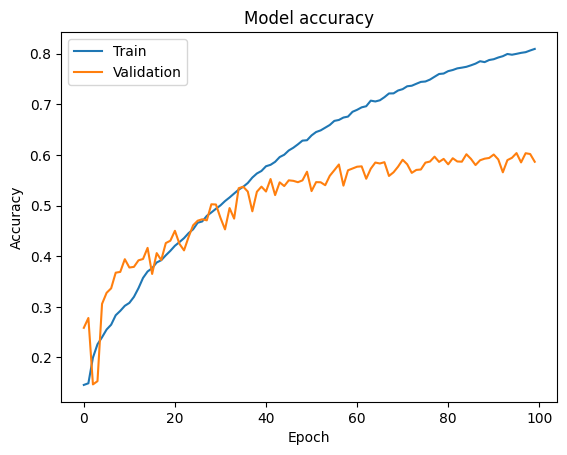

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Loss Plot

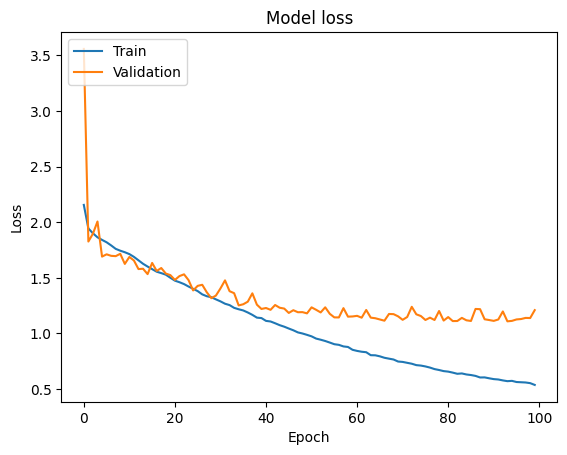

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()